## Plot time series of SEA-POL low-level rain rate
From PICCOLO_level4_rainrate_2D.nc

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, colors, ticker
import matplotlib.dates as mdates
from scipy.interpolate import interp2d, RectBivariateSpline
from datetime import datetime, timedelta
import pandas as pd
import cftime
import seaborn as sns
import json
from matplotlib import rc
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap,Normalize
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker
#import cmweather
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
# Define color-blind safe colors
cb_orange = [230/255, 159/255, 0]
cb_skyblue = [86/255, 180/255, 233/255]
cb_green = [0, 158/255, 115/255]
cb_yellow = [240/255, 228/255, 66/255]
cb_blue = [0, 114/255, 178/255]
cb_red = [213/255, 94/255, 0]
cb_purple = [204/255, 121/255, 167/255]


 Read in data

In [3]:
seapol = xr.open_dataset('../../data/SEA-POL_4_rainrate_2D_spatial_means_reg10.nc')
seapol

<xarray.Dataset> Size: 707kB
Dimensions:       (time: 5526)
Coordinates:
  * time          (time) datetime64[ns] 44kB 2024-08-16T08:00:00 ... 2024-09-...
Data variables: (12/15)
    rain245_mean  (time) float64 44kB ...
    rain120_mean  (time) float64 44kB ...
    rain60_mean   (time) float64 44kB ...
    rain12_mean   (time) float64 44kB ...
    rain1_mean    (time) float64 44kB ...
    rain245_int   (time) float64 44kB ...
    ...            ...
    rain1_int     (time) float64 44kB ...
    rain245_frac  (time) float64 44kB ...
    rain120_frac  (time) float64 44kB ...
    rain60_frac   (time) float64 44kB ...
    rain12_frac   (time) float64 44kB ...
    rain1_frac    (time) float64 44kB ...
Attributes:
    title:        Spatial mean rainrate from SEA-POL long-range, low-elevatio...
    description:  Spatial means of rainrate from SEA-POL long-range, low-elev...
    source:       SEA-POL Level4b Gridded 2D Rain Rate
    units:        mm/h

Plot area-mean precip & precip intensity time series

/tmp/ipykernel_3483214/3816150567.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=18)
/tmp/ipykernel_3483214/3816150567.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=18)
/tmp/ipykernel_3483214/3816150567.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=18)
/tmp/ipykernel_3483214/3816150567.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(axs[1].get_xticklabels(), fontsize=18)
/tmp/ipykernel_3483214/3816150567.py:43: UserWarning: set_ticklabels

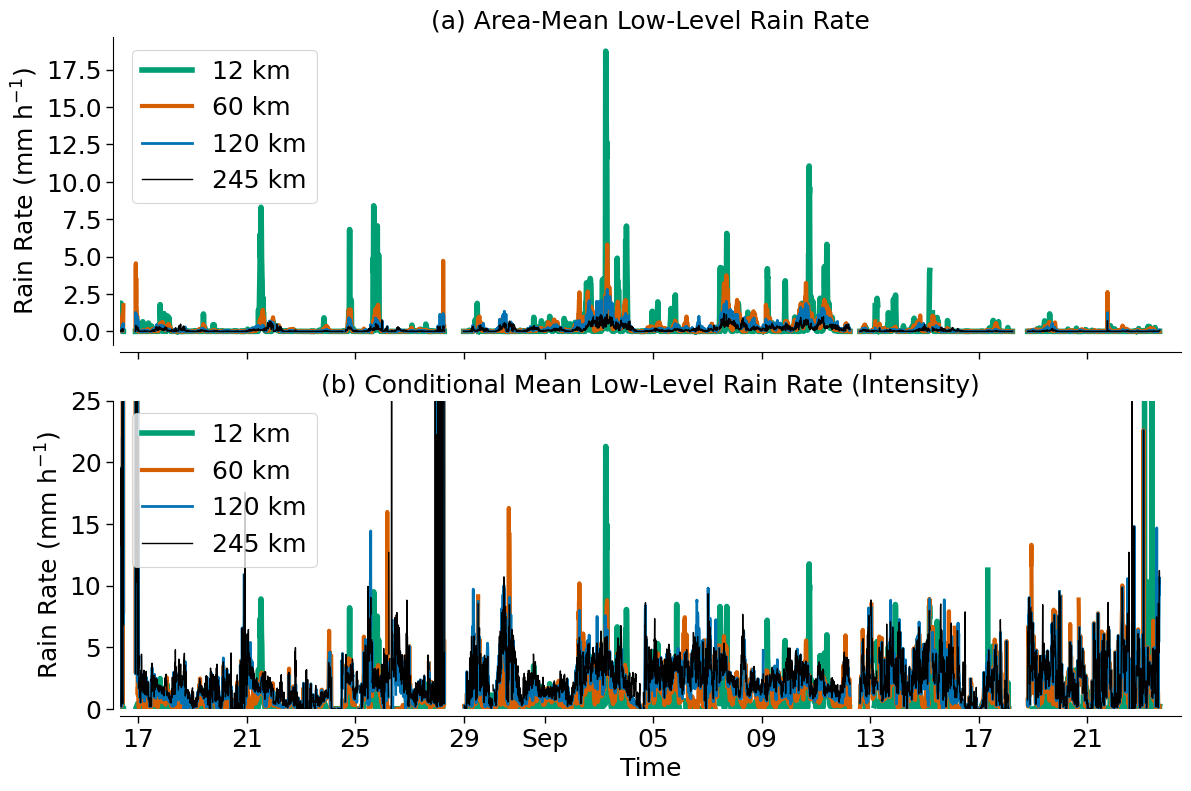

In [4]:
#Plot for whole campaign (10 minute data)

fig,axs = plt.subplots(2,1,figsize=(12,8),layout="constrained")

axs[0].plot(seapol.time, seapol.rain12_mean, color=cb_green, label='12 km', linewidth=4)
axs[0].plot(seapol.time, seapol.rain60_mean, color=cb_red, label='60 km', linewidth=3)
axs[0].plot(seapol.time, seapol.rain120_mean, color=cb_blue, label='120 km', linewidth=2)
axs[0].plot(seapol.time, seapol.rain245_mean, color='black', label='245 km', linewidth=1)
axs[0].set_title('(a) Area-Mean Low-Level Rain Rate',fontsize=18)
axs[0].set_ylabel('Rain Rate (mm h$^{-1}$)', fontsize=18)
#axs[0].set_xlabel('Time',fontsize=18)

sns.set_context('paper') 
sns.despine(offset=5)

axs[0].set_xlim(pd.Timestamp('2024-08-16 07:30'), pd.Timestamp('2024-09-24 11:30'))

axs[0].legend(loc='upper left', fontsize=18)
axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=18)
axs[0].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[0].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[0].xaxis.get_major_locator()))

axs[0].set_xticklabels([])
axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=18)

axs[1].plot(seapol.time, seapol.rain12_int, color=cb_green, label='12 km', linewidth=4)
axs[1].plot(seapol.time, seapol.rain60_int, color=cb_red, label='60 km', linewidth=3)
axs[1].plot(seapol.time, seapol.rain120_int, color=cb_blue, label='120 km', linewidth=2)
axs[1].plot(seapol.time, seapol.rain245_int, color='black', label='245 km', linewidth=1)
axs[1].set_title('(b) Conditional Mean Low-Level Rain Rate (Intensity)',fontsize=18)
axs[1].set_ylabel('Rain Rate (mm h$^{-1}$)', fontsize=18)
axs[1].set_xlabel('Time',fontsize=18)

axs[1].set_ylim(0,25)
axs[1].set_xlim(pd.Timestamp('2024-08-16 07:30'), pd.Timestamp('2024-09-24 11:30'))

axs[1].legend(loc='upper left', fontsize=18)
axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=18)
axs[1].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[1].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[1].xaxis.get_major_locator()))

axs[1].set_xticklabels(axs[1].get_xticklabels(), fontsize=18)
axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=18)

plt.tight_layout() 

In [5]:
#Find where intensity greater than 25
rain245int_gt25 = np.where(seapol.rain245_int > 25)[0]
print('rain245int > 25:',seapol.rain245_int[rain245int_gt25].values)
print('rain245int > 25 times:',seapol.time[rain245int_gt25].values)

rain120int_gt25 = np.where(seapol.rain120_int > 25)[0]
print('rain120int > 25:',seapol.rain120_int[rain120int_gt25].values)
print('rain120int > 25 times:',seapol.time[rain120int_gt25].values)

rain60int_gt25 = np.where(seapol.rain60_int > 25)[0]
print('rain60int > 25:',seapol.rain60_int[rain60int_gt25].values)
print('rain60int > 25 times:',seapol.time[rain60int_gt25].values)


rain245int > 25: [ 32.61317444  42.11698914  43.69174576  45.99090576  33.87711716
  32.17262268  35.33061218  29.1096096   38.55671692  27.75573158
  42.50668716  37.58618927  68.59971619  52.33507538  36.06376266
  96.35497284  34.64147186  25.08762169  27.0318203   37.68011856
 103.63066864  39.53708649  75.59577942  64.77958679  38.49164581
  60.86788177  46.9375267   54.20727539]
rain245int > 25 times: ['2024-08-16T09:40:00.000000000' '2024-08-16T10:10:00.000000000'
 '2024-08-16T10:40:00.000000000' '2024-08-16T21:30:00.000000000'
 '2024-08-16T21:40:00.000000000' '2024-08-16T21:50:00.000000000'
 '2024-08-16T22:00:00.000000000' '2024-08-16T22:10:00.000000000'
 '2024-08-16T22:20:00.000000000' '2024-08-16T22:50:00.000000000'
 '2024-08-26T08:10:00.000000000' '2024-08-27T22:50:00.000000000'
 '2024-08-28T01:10:00.000000000' '2024-08-28T02:30:00.000000000'
 '2024-08-28T02:50:00.000000000' '2024-08-28T03:00:00.000000000'
 '2024-08-28T03:30:00.000000000' '2024-08-28T04:20:00.000000000'
 '20

Coarsen SEA-POL data to hourly (block average)

In [6]:
rain245_hrly = seapol.rain245_mean.coarsen(time=6,boundary='exact',coord_func={'time':'min'}).mean(skipna='true') #6 10-minute intervals = 1 hour
rain120_hrly = seapol.rain120_mean.coarsen(time=6,boundary='exact',coord_func={'time':'min'}).mean(skipna='true')
rain60_hrly = seapol.rain60_mean.coarsen(time=6,boundary='exact',coord_func={'time':'min'}).mean(skipna='true')
rain12_hrly = seapol.rain12_mean.coarsen(time=6,boundary='exact',coord_func={'time':'min'}).mean(skipna='true')
rain1_hrly = seapol.rain1_mean.coarsen(time=6,boundary='exact',coord_func={'time':'min'}).mean(skipna='true')

rain245int_hrly = seapol.rain245_int.coarsen(time=6,boundary='exact',coord_func={'time':'min'}).mean(skipna='true')
rain120int_hrly = seapol.rain120_int.coarsen(time=6,boundary='exact',coord_func={'time':'min'}).mean(skipna='true')
rain60int_hrly = seapol.rain60_int.coarsen(time=6,boundary='exact',coord_func={'time':'min'}).mean(skipna='true')
rain12int_hrly = seapol.rain12_int.coarsen(time=6,boundary='exact',coord_func={'time':'min'}).mean(skipna='true')
rain1int_hrly = seapol.rain1_int.coarsen(time=6,boundary='exact',coord_func={'time':'min'}).mean(skipna='true')

rain245frac_hrly = seapol.rain245_frac.coarsen(time=6,boundary='exact',coord_func={'time':'min'}).mean(skipna='true')
rain120frac_hrly = seapol.rain120_frac.coarsen(time=6,boundary='exact',coord_func={'time':'min'}).mean(skipna='true')
rain60frac_hrly = seapol.rain60_frac.coarsen(time=6,boundary='exact',coord_func={'time':'min'}).mean(skipna='true')
rain12frac_hrly = seapol.rain12_frac.coarsen(time=6,boundary='exact',coord_func={'time':'min'}).mean(skipna='true')
rain1frac_hrly = seapol.rain1_frac.coarsen(time=6,boundary='exact',coord_func={'time':'min'}).mean(skipna='true')

In [7]:
#find where intensity greater than 11 in hourly data
rain245int_hrly_gt11 = np.where(rain245int_hrly > 11)[0]
print('rain245int_hrly > 11:',rain245int_hrly[rain245int_hrly_gt11].values)
print('rain245int_hrly > 11 times:',rain245int_hrly.time[rain245int_hrly_gt11].values)

rain245int_hrly > 11: [23.05007156 28.72916442 27.07485755 13.51312562 12.88272071 19.09614825
 16.6677019  27.11274697 46.75832662 36.00750751 14.54141017]
rain245int_hrly > 11 times: ['2024-08-16T10:00:00.000000000' '2024-08-16T21:00:00.000000000'
 '2024-08-16T22:00:00.000000000' '2024-08-16T23:00:00.000000000'
 '2024-08-26T08:00:00.000000000' '2024-08-28T01:00:00.000000000'
 '2024-08-28T02:00:00.000000000' '2024-08-28T03:00:00.000000000'
 '2024-08-28T05:00:00.000000000' '2024-08-28T06:00:00.000000000'
 '2024-09-22T15:00:00.000000000']


Read in IMERG and ERA_5 along track data. 

IMERG has been interpolated to a 0.25 degree grid and coarsened to hourly resolution. 

In [8]:
alongtrack = xr.open_dataset('../../data/IWVprecip_alongtrack.nc')
#precip_alongtrack_imerg
#precip_alongtrack_era5

Plot

/tmp/ipykernel_3483214/1702063557.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(axs[0].get_yticklabels(), fontsize=18)
/tmp/ipykernel_3483214/1702063557.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/tmp/ipykernel_3483214/1702063557.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
/tmp/ipykernel_3483214/1702063557.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


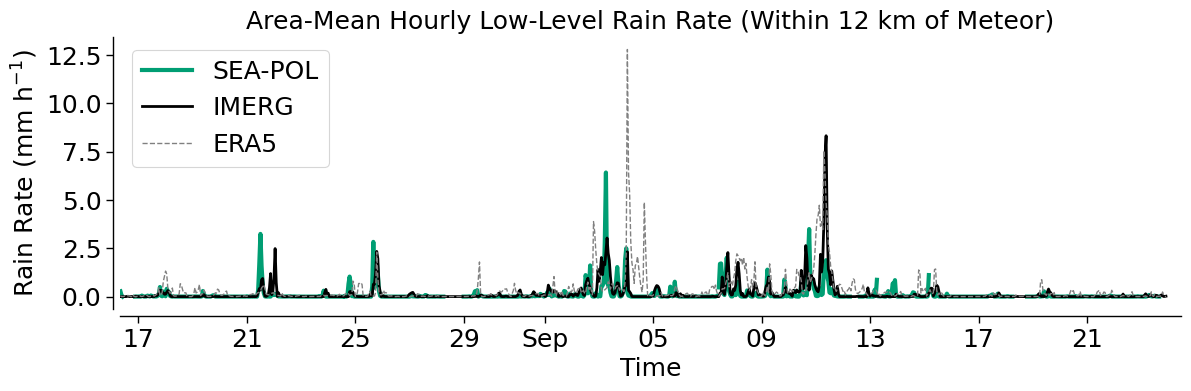

In [9]:
#Plot for whole campaign (hourly data)

fig,ax = plt.subplots(figsize=(12,4),layout="constrained")

ax.plot(rain12_hrly.time, rain12_hrly, color=cb_green, label='SEA-POL', linewidth=3)
ax.plot(alongtrack.time, alongtrack.precip_alongtrack_imerg, color='black', label='IMERG', linewidth=2)
ax.plot(alongtrack.time, alongtrack.precip_alongtrack_era5, color='gray', label='ERA5', linewidth=1, linestyle = '--')

sns.set_context('paper') 
sns.despine(offset=5)

ax.set_title('Area-Mean Hourly Low-Level Rain Rate (Within 12 km of Meteor)',fontsize=18)
ax.set_ylabel('Rain Rate (mm h$^{-1}$)', fontsize=18)
ax.set_xlabel('Time',fontsize=18)

ax.set_xlim(pd.Timestamp('2024-08-16 07:30'), pd.Timestamp('2024-09-24 11:30'))

ax.legend(loc='upper left', fontsize=18)
ax.set_yticklabels(axs[0].get_yticklabels(), fontsize=18)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[0].xaxis.get_major_locator()))

ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

plt.tight_layout() 


/tmp/ipykernel_3483214/3069777657.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=18)
/tmp/ipykernel_3483214/3069777657.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=18)
/tmp/ipykernel_3483214/3069777657.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=18)
/tmp/ipykernel_3483214/3069777657.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=18)
/tmp/ipykernel_3483214/3069777657.py:58: UserWarning: set_ticklabels

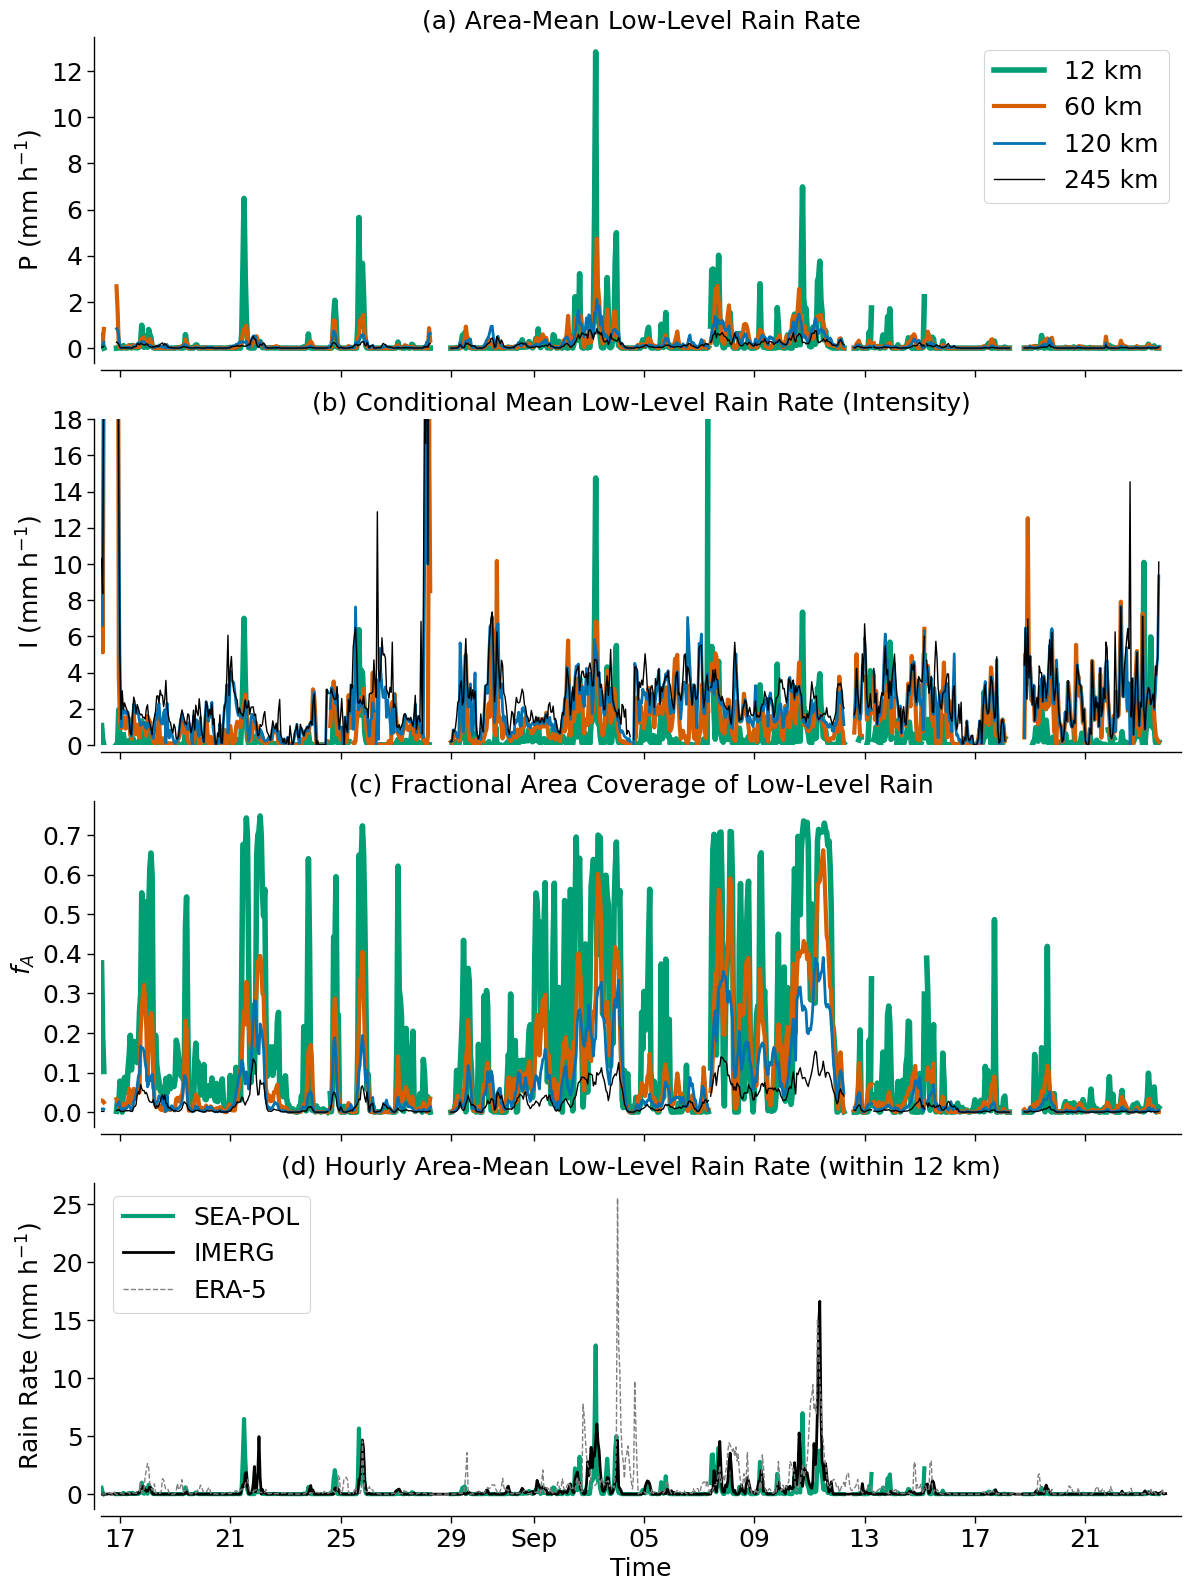

In [10]:
#Plot for whole campaign (10 minute data)

fig,axs = plt.subplots(4,1,figsize=(12,16),layout="constrained")

axs[0].plot(rain12_hrly.time, rain12_hrly, color=cb_green, label='12 km', linewidth=4)
axs[0].plot(rain60_hrly.time, rain60_hrly, color=cb_red, label='60 km', linewidth=3)
axs[0].plot(rain120_hrly.time, rain120_hrly, color=cb_blue, label='120 km', linewidth=2)
axs[0].plot(rain245_hrly.time, rain245_hrly, color='black', label='245 km', linewidth=1)
axs[0].set_title('(a) Area-Mean Low-Level Rain Rate',fontsize=18)
axs[0].set_ylabel('P (mm h$^{-1}$)', fontsize=18)
#axs[0].set_xlabel('Time',fontsize=18)

sns.set_context('paper') 
sns.despine(offset=5)

#axs[0].set_ylim(0,10)
axs[0].set_xlim(pd.Timestamp('2024-08-16 07:30'), pd.Timestamp('2024-09-24 11:30'))

axs[0].legend(loc='upper right', fontsize=18)
axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=18)
axs[0].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[0].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[0].xaxis.get_major_locator()))

axs[0].set_xticklabels([])
axs[0].set_yticklabels(axs[0].get_yticklabels(), fontsize=18)

axs[1].plot(rain12int_hrly.time, rain12int_hrly, color=cb_green, label='12 km', linewidth=4)
axs[1].plot(rain60int_hrly.time, rain60int_hrly, color=cb_red, label='60 km', linewidth=3)
axs[1].plot(rain120int_hrly.time, rain120int_hrly, color=cb_blue, label='120 km', linewidth=2)
axs[1].plot(rain245int_hrly.time, rain245int_hrly, color='black', label='245 km', linewidth=1)
axs[1].set_title('(b) Conditional Mean Low-Level Rain Rate (Intensity)',fontsize=18)
axs[1].set_ylabel('I (mm h$^{-1}$)', fontsize=18)
#axs[1].set_xlabel('Time',fontsize=18)

axs[1].set_ylim(0,18)
axs[1].set_xlim(pd.Timestamp('2024-08-16 07:30'), pd.Timestamp('2024-09-24 11:30'))

#axs[1].legend(loc='upper left', fontsize=18)
axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=18)
axs[1].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[1].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[1].xaxis.get_major_locator()))

axs[1].set_xticklabels([])
axs[1].set_yticklabels(axs[1].get_yticklabels(), fontsize=18)

axs[2].plot(rain12frac_hrly.time, rain12frac_hrly, color=cb_green, label='12 km', linewidth=4)
axs[2].plot(rain60frac_hrly.time, rain60frac_hrly, color=cb_red, label='60 km', linewidth=3)
axs[2].plot(rain120frac_hrly.time, rain120frac_hrly, color=cb_blue, label='120 km', linewidth=2)
axs[2].plot(rain245frac_hrly.time, rain245frac_hrly, color='black', label='245 km', linewidth=1)
axs[2].set_title('(c) Fractional Area Coverage of Low-Level Rain',fontsize=18)
axs[2].set_ylabel('$f_A$', fontsize=18)
#axs[2].set_xlabel('Time',fontsize=18)

#axs[2].set_ylim(0,25)
axs[2].set_xlim(pd.Timestamp('2024-08-16 07:30'), pd.Timestamp('2024-09-24 11:30'))

#axs[2].legend(loc='upper left', fontsize=18)
axs[2].set_yticklabels(axs[2].get_yticklabels(), fontsize=18)
axs[2].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[2].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[2].xaxis.get_major_locator()))

axs[2].set_xticklabels([])
axs[2].set_yticklabels(axs[2].get_yticklabels(), fontsize=18)

axs[3].plot(rain12_hrly.time, rain12_hrly, color=cb_green, label='SEA-POL', linewidth=3)
axs[3].plot(alongtrack.time, alongtrack.precip_alongtrack_imerg, color='black', label='IMERG', linewidth=2)
axs[3].plot(alongtrack.time, alongtrack.precip_alongtrack_era5, color='gray', label='ERA-5', linewidth=1, linestyle = '--')

axs[3].set_title('(d) Hourly Area-Mean Low-Level Rain Rate (within 12 km)',fontsize=18)
axs[3].set_ylabel('Rain Rate (mm h$^{-1}$)', fontsize=18)
axs[3].set_xlabel('Time',fontsize=18)

axs[3].set_xlim(pd.Timestamp('2024-08-16 07:30'), pd.Timestamp('2024-09-24 11:30'))

axs[3].legend(loc='upper left', fontsize=18)
axs[3].set_yticklabels(axs[3].get_yticklabels(), fontsize=18)
axs[3].xaxis.set_major_locator(mdates.AutoDateLocator())
axs[3].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axs[3].xaxis.get_major_locator()))

axs[3].set_xticklabels(axs[3].get_xticklabels(), fontsize=18)
axs[3].set_yticklabels(axs[3].get_yticklabels(), fontsize=18)

plt.tight_layout() 

plt.savefig('../../figures/Fig_precip_timeseries.png')

In [11]:
#find where alongtrack.time is rain12_hrly.time[-1]
rain12_hrly_time = pd.to_datetime(rain12_hrly.time.values)
last_time = rain12_hrly_time[-1]
alongtrack_time = pd.to_datetime(alongtrack.time.values)
last_alongtrack_idx = np.where(alongtrack_time == last_time)[0][0]

/var/folders/j4/wzfdxl397kl09v45hngwvxd80000gp/T/ipykernel_704/1465051337.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
/var/folders/j4/wzfdxl397kl09v45hngwvxd80000gp/T/ipykernel_704/1465051337.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
/var/folders/j4/wzfdxl397kl09v45hngwvxd80000gp/T/ipykernel_704/1465051337.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


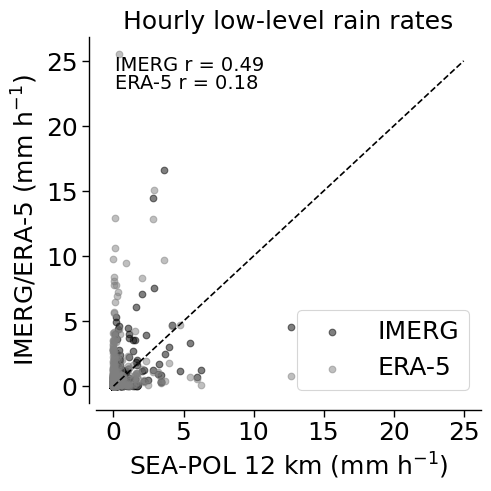

In [11]:
# Scatter plot of imerg and era-5 against rain12_hrly
fig, ax = plt.subplots(figsize=(5, 5), layout="constrained")
ax.scatter(rain12_hrly,alongtrack.precip_alongtrack_imerg[0:last_alongtrack_idx+1], color='black', label='IMERG', alpha=0.5)
ax.scatter(rain12_hrly,alongtrack.precip_alongtrack_era5[0:last_alongtrack_idx+1], color='gray', label='ERA-5', alpha=0.5)

#plot 1:1 line
x = np.linspace(0, 25, 100)
ax.plot(x, x, color='black', linestyle='--')

#calculate correlation coefficient, ignoring nans
corr_imerg = np.corrcoef(rain12_hrly[~np.isnan(rain12_hrly)], alongtrack.precip_alongtrack_imerg[0:last_alongtrack_idx+1][~np.isnan(rain12_hrly)])[0, 1]
corr_era5 = np.corrcoef(rain12_hrly[~np.isnan(rain12_hrly)], alongtrack.precip_alongtrack_era5[0:last_alongtrack_idx+1][~np.isnan(rain12_hrly)])[0, 1]
ax.text(0.05, 0.95, f'IMERG r = {corr_imerg:.2f}', transform=ax.transAxes, fontsize=14, verticalalignment='top')
ax.text(0.05, 0.90, f'ERA-5 r = {corr_era5:.2f}', transform=ax.transAxes, fontsize=14, verticalalignment='top')

sns.set_context('paper') 
sns.despine(offset=5)

ax.set_ylabel('IMERG/ERA-5 (mm h$^{-1}$)', fontsize=18)
ax.set_xlabel('SEA-POL 12 km (mm h$^{-1}$)', fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=18)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
ax.set_title('Hourly low-level rain rates', fontsize=18)
ax.legend(fontsize=18)

plt.tight_layout() 

SEA-POL hourly running mean

In [12]:
# SEA-POL hourly running mean
rain12_hrly_run = seapol.rain12_mean.rolling(time=6, center=True).mean() # 6*10=60 minute running mean

/var/folders/j4/wzfdxl397kl09v45hngwvxd80000gp/T/ipykernel_704/422553208.py:27: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


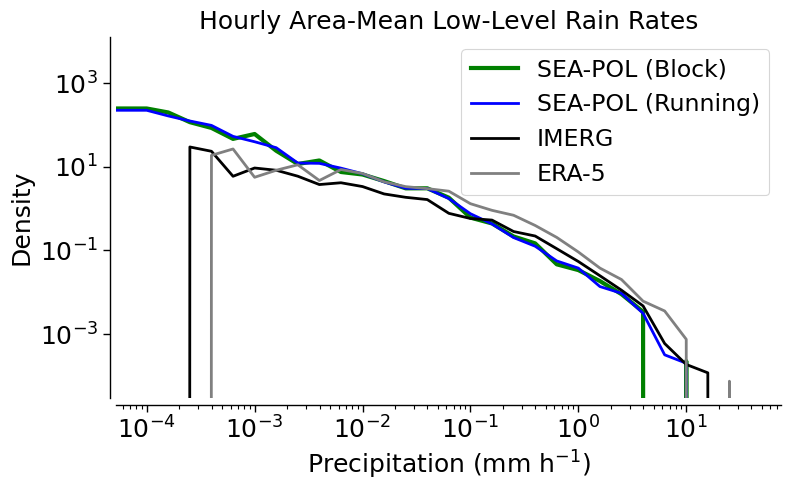

In [13]:
fig,ax = plt.subplots(figsize=(8,5),layout="constrained")

pbins = np.concatenate(([0],np.power(10,np.arange(-4,2,0.2))))

## SEA-POL 12 km
phist_seapol12, bin_edges = np.histogram(rain12_hrly, bins=pbins, density=True)
phist_seapol12_run, bin_edges = np.histogram(rain12_hrly_run, bins=pbins, density=True)
phist_imerg, bin_edges = np.histogram(alongtrack.precip_alongtrack_imerg[0:last_alongtrack_idx+1], bins=pbins, density=True)
phist_era5, bin_edges = np.histogram(alongtrack.precip_alongtrack_era5[0:last_alongtrack_idx+1], bins=pbins, density=True)

ax.plot(bin_edges[:-1], phist_seapol12, color='green', label='SEA-POL (Block)', linewidth=3)
ax.plot(bin_edges[:-1], phist_seapol12_run, color='blue', label='SEA-POL (Running)', linewidth=2)
ax.plot(bin_edges[:-1], phist_imerg, color='black', label='IMERG',linewidth=2)
ax.plot(bin_edges[:-1], phist_era5, color='gray', label='ERA-5',linewidth=2)

ax.set_title('Hourly Area-Mean Low-Level Rain Rates',fontsize=18)
ax.set_xlabel('Precipitation (mm h$^{-1}$)',fontsize=18)
ax.set_ylabel('Density',fontsize=18)
#ax.set_xlim(0,25)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize=17, loc='upper right')
ax.tick_params(labelsize=18)

sns.set_context('paper') 
sns.despine(offset=5)
plt.tight_layout() 

plt.savefig('../../figures/Fig_SEAPOL_IMERG_ERA5_pdf.png')